<h1 style="background-color:white;font-family:rockwell;font-size:290%;text-align:center">Sarcasm Detection</h1>

*********************************************************

![](sar1.png)

### Contents
* [**Abstract**](#abstract)
* [**Dataset**](#dataset)
* [**Importing Dataset and the required libraries**](#import)
* [**Visualizing the Target distribution**](#graph)
* [**Data Cleaning and Pre-processing**](#cleaning)
* [**Classification Algorithms**](#part-b)
    * [Spliting the dataset](#train-test-split)
    * [Logistic Regression](#log)
    * [Random Forest Classifier](#rfc)
    * [Convolution Neural Network](#cnn)
* [**Conclusion**](#conclusion)

### Abstract
Sarcasm detection is a very narrow research field in NLP, a specific case of sentiment analysis where instead of detecting a sentiment in the whole spectrum, the focus is on sarcasm. Therefore the task of this field is to detect if a given text is sarcastic or not.

This dataset is large compared to the other datasets, yet very small compared to the datasets used in DL models. It is imbalanced, meaning there are more non-sarcastic tweets than sarcastic, which is realistic since sarcasm is very rare in our daily interactions and datasets should represent reality as best as they can. And regarding the type of sarcasm, this dataset captures intended sarcasm, this tweet is labelled as sarcastic because the author wants it to be, it doesn’t consider people’s perception.


<a id = 'dataset'></a>
### Dataset
The dataset which is used in this project, is collected from Kaggle. Here is the link of the dataset : https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection?select=Sarcasm_Headlines_Dataset.json

<a id = 'import'></a>
### Importing the Dataset and the required libraries

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso, Huber, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
import tensorflow as tf
import json

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
! python -m spacy download en_core_web_md

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
     |████████████████████████████████| 50.8 MB 7.0 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.3.1-py3-none-any.whl size=50916640 sha256=3ad116d0cc53af141dc7339b20fb7c67f02ea16d44def9cde919438b62d95933
  Stored in directory: /tmp/pip-ephem-wheel-cache-33lk8rnv/wheels/43/1d/c1/a0af68d0648debf57f875e9dda56bbac35cfc27bfa187ffc46
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


**Data distribution into two parts, for the better using purposes**

In [4]:
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

data_v1 = list(parse_data('/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json'))
data_v2 = list(parse_data('/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json'))

**Adding the labels as `text` and `Label`**

In [5]:
def create_dataframe(list_of_dicts):
    all_headlines = [i['headline'] for i in list_of_dicts]
    all_labels = [i['is_sarcastic'] for i in list_of_dicts]
    return pd.DataFrame({"Text":all_headlines, "Label":all_labels})

**Dividing the data into test and training set of data**

In [6]:
train_df = create_dataframe(data_v1)
test_df = create_dataframe(data_v2)

In [7]:
print(train_df.head())
print(test_df.head())

                                                Text  Label
0  former versace store clerk sues over secret 'b...      0
1  the 'roseanne' revival catches up to our thorn...      0
2  mom starting to fear son's web series closest ...      1
3  boehner just wants wife to listen, not come up...      1
4  j.k. rowling wishes snape happy birthday in th...      0
                                                Text  Label
0  thirtysomething scientists unveil doomsday clo...      1
1  dem rep. totally nails why congress is falling...      0
2  eat your veggies: 9 deliciously different recipes      0
3  inclement weather prevents liar from getting t...      1
4  mother comes pretty close to using word 'strea...      1


**Shape of the Training Dataset and Test Dataset**

In [8]:
print(train_df.shape, test_df.shape)

(26709, 2) (28619, 2)


**Concatenate the training and testing set into a single data frame for the model deployment**

In [9]:
all_data = pd.concat([train_df, test_df], axis=0)
print(all_data.shape)

(55328, 2)


<a id = 'graph'></a>
### Visualizing the Target Distribution
Data visualization is a technique that uses an array of static and interactive visuals within a specific context to help people understand and make sense of large amounts of data. The data is often displayed in a story format that visualizes patterns, trends and correlations that may otherwise go unnoticed.

Text(0.5, 1.0, 'Target Distribution')

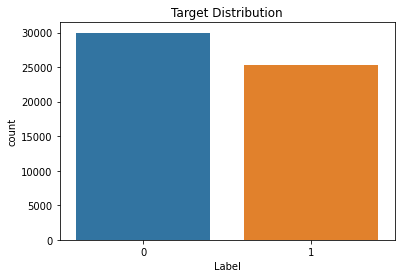

In [10]:
sns.countplot(x='Label', data=all_data);
plt.title('Target Distribution')

<a id = 'cleaning'></a>
### Data Cleaning and Data Preprocessing
Data cleansing or data cleaning is the process of detecting and correcting (or removing) corrupt or inaccurate records from a record set, table, or database and refers to identifying incomplete, incorrect, inaccurate or irrelevant parts of the data and then replacing, modifying, or deleting the dirty or coarse data.

In [11]:
def clean_text(x):
  
  #x = re.sub(r"\W", " ", x)
  x = re.sub(r"[0-9]", " ", x)
  x = re.sub(r"\s{2,}", " ", x)
  return x.strip()

def clean_text2(x):
  
  #x = re.sub(r"\W", " ", x)
  #x = re.sub(r"[0-9]", " ", x)
  x = re.sub(r"\s{2,}", " ", x)
  x = re.sub(r" s ", " ", x)
  
  return x.strip()

In [12]:
#all_clean_text = [clean_text2(clean_text(i)) for i in all_data['Text'].tolist()]
all_clean_text = all_data['Text'].tolist()

-------------------------------

<a id="part-b"></a>
## Classification Algorithms
A classification model tries to draw some conclusion from the input values given for training. It will predict the class labels/categories for the new data.

Here we are going to prepare several Classification machine learning models based on those we will do a comparative analysis that which model is better among them.

A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. In this sense, neural networks refer to systems of neurons, either organic or artificial in nature. Neural networks can adapt to changing input; so the network generates the best possible result without needing to redesign the output criteria. The concept of neural networks, which has its roots in artificial intelligence, is swiftly gaining popularity in the development of trading systems.

Mainly I have used the Logistic Regression and Random Forest Classifier and a Sequential model which is Convolution Neural Network.

We are using three different classification algorithms -
* **Random Forest Classifier** : Random Forest is a popular machine learning algorithm that belongs to the supervised learning technique. It can be used for both Classification and Regression problems in ML. It is based on the concept of ensemble learning, which is a process of combining multiple classifiers to solve a complex problem and to improve the performance of the model.


* **Logistic Regression** : Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression).


* **Convolution Neural Network of CNN** : In deep learning, a convolutional neural network (CNN/ConvNet) is a class of deep neural networks, most commonly applied to analyze visual imagery. Now when we think of a neural network we think about matrix multiplications but that is not the case with ConvNet. It uses a special technique called Convolution. Now in mathematics convolution is a mathematical operation on two functions that produces a third function that expresses how the shape of one is modified by the other.

Let's quickly get into the algorithms!

In [13]:
tfidf = TfidfVectorizer(ngram_range=(2, 3), max_df=1000, min_df=10)
tfidf.fit(all_clean_text)

TfidfVectorizer(max_df=1000, min_df=10, ngram_range=(2, 3))

In [14]:
tfidf_feats = tfidf.transform(all_clean_text)

<a id="train-test-split"></a>
**Training and Testing Dataset Spliting using the `train_test_split`**
  
  * Immporting the library from the sklearn.model_selection
  * Split the training dataset into 60:40 ratio
  * name the distributed training dataset as, trainx and trainy.
  * Split the testing dataset into 50:50 ratio.
  * name the distributed testing dataset as testx and testy.
  * testvalx and testvaly are the validation trainning datasets
  * valx and valy are the validation testing datasets
  * After the spliting of the datasets the model is ready to be prepared!

In [15]:
trainx, testvalx, trainy, testvaly = train_test_split(tfidf_feats, all_data['Label'].tolist(), test_size=0.4)
valx, testx, valy, testy = train_test_split(testvalx, testvaly, test_size=0.5)

<a id = 'log'></a>
### Logistic Regression
 Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression).

In [16]:
lr = LogisticRegression(C=10)
lr.fit(trainx, trainy)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10)

In [17]:
print(f"Validation Set Score: {lr.score(valx, valy)}")
print(f"Test Set Score: {lr.score(testx, testy)}")

Validation Set Score: 0.7623350804265318
Test Set Score: 0.7565515994939455


<a id = 'rfc'></a>
### Random Forest Classifier
Random Forest is a popular machine learning algorithm that belongs to the supervised learning technique. It can be used for both Classification and Regression problems in ML. It is based on the concept of ensemble learning, which is a process of combining multiple classifiers to solve a complex problem and to improve the performance of the model.

In [18]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(trainx, trainy)
print(f"Validation Set Score: {rf.score(valx, valy)}")
print(f"Test Set Score: {rf.score(testx, testy)}")

Validation Set Score: 0.7969455991324779
Test Set Score: 0.7958611964576179


<a id = 'cnn'></a>
### Convolution Neural Network (CNN)
There are three types of layers that make up the CNN which are the convolutional layers, pooling layers, and fully-connected (FC) layers. When these layers are stacked, a CNN architecture will be formed.
> 1. **Convolution Layer** :This layer is the first layer that is used to extract the various features from the input images.
> 2. **Pooling Layer** : The primary aim of this layer is to decrease the size of the convolved feature map to reduce the computational costs.
> 3. **Fully Connected Layer** : The Fully Connected (FC) layer consists of the weights and biases along with the neurons and is used to connect the neurons between two different layers.
> 4. **Dropout** : Dit decides which information of the model should fire in the forward direction and which ones should not at the end of the network.ropout layer is utilised wherein a few neurons are dropped from the neural network during training process resulting in reduced size of the model.
> 5. **Activation Functions** : It decides which information of the model should fire in the forward direction and which ones should not at the end of the network.

![](cnn.png)

In [19]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-05-23 06:14:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-23 06:14:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-23 06:14:40--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [20]:
#Load pretrained GloVe embeddings
dict_w2v = {}
with open('glove.6B.100d.txt', "r") as file:
    for line in file:
        tokens = line.split()
        word = tokens[0]
        vector = np.array(tokens[1:], dtype=np.float32)
        if vector.shape[0] == 100:
            dict_w2v[word] = vector
        else:
            print("There was an issue with " + word)
# let's check the vocabulary size
print("Dictionary Size: ", len(dict_w2v))

Dictionary Size:  400000


In [21]:
NUM_WORDS = 10000
NUM_CLS = 2

In [22]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters="")
tokenizer.fit_on_texts(all_clean_text)

In [23]:
NUM_WORDS = len(tokenizer.word_index) + 1
print(NUM_WORDS)

38246


**Cleaning the dataset and preparing for the model fit**

In [24]:
embedding_dim = 100
embedding_matrix = np.zeros((NUM_WORDS, embedding_dim))

unk_cnt = 0
unk_set = set()
for word in tokenizer.word_index.keys():
    embedding_vector = dict_w2v.get(word)
    if embedding_vector is not None:
        tkn_id = tokenizer.word_index[word]
        embedding_matrix[tkn_id] = embedding_vector
    else:
        unk_cnt += 1
        unk_set.add(word)
# Print how many weren't found
print("Total unknown words: ", unk_cnt)

Total unknown words:  13190


In [25]:
all_sequences = tokenizer.texts_to_sequences(all_clean_text)
all_padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(all_sequences)

<a id="train-test-split"></a>
**Training and Testing Dataset Spliting using the `train_test_split`**
  
  * Immporting the library from the sklearn.model_selection
  * Split the training dataset into 60:40 ratio
  * name the distributed training dataset as, trainx and trainy.
  * Split the testing dataset into 50:50 ratio.
  * name the distributed testing dataset as testx and testy.
  * testvalx and testvaly are the validation trainning datasets
  * valx and valy are the validation testing datasets
  * After the spliting of the datasets the model is ready to be prepared!

In [26]:
train_x, valtest_x, train_y, valtest_y = train_test_split(all_padded_sequences, np.asarray(all_data['Label'].tolist(), dtype=np.int32), test_size=0.4)
val_x, test_x, val_y, test_y = train_test_split(valtest_x, valtest_y, test_size=0.5)

In [27]:
print(train_x.shape, val_x.shape, test_x.shape, val_y.shape, train_y.shape, test_y.shape)
train_x, train_y = train_x[:(train_x.shape[0]//32)*32, :], train_y[:(train_y.shape[0]//32)*32]
val_x, val_y = val_x[:(val_x.shape[0]//32)*32, :], val_y[:(val_y.shape[0]//32)*32]
test_x, test_y = test_x[:(test_x.shape[0]//32)*32, :], test_y[:(test_y.shape[0]//32)*32]

(33196, 151) (11066, 151) (11066, 151) (11066,) (33196,) (11066,)


In [28]:
class MergeHiddenStates(tf.keras.layers.Layer):
  def __init__(self):
    super(MergeHiddenStates, self).__init__()
  
  def call(self, inputs):
    #print(inputs)
    states = inputs#[0]
    return tf.reduce_mean(states, axis=1)

**Model Creation using Tensorflow and Keras**

In [29]:
def create_model(input_shape=(train_x.shape[1], ), vocabsize=NUM_WORDS, emb_dim=50, rnn_units=128, batch_size=32):
  model = tf.keras.Sequential([
                               tf.keras.layers.Embedding(
                                   vocabsize,
                                   emb_dim,
                                   mask_zero=False,
                                   batch_input_shape=(batch_size, input_shape[0]),
                                   weights=[embedding_matrix], trainable=True
                               ),
                               tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_units, dropout=0.2, return_sequences=True)),
                               MergeHiddenStates(),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Dense(128, activation='relu'),
                               tf.keras.layers.Dropout(0.2),
                               tf.keras.layers.Dense(NUM_CLS, activation='softmax')
  ])
  return model

def create_model_v2(input_shape=(train_x.shape[1], ), vocabsize=NUM_WORDS, emb_dim=100, rnn_units=128, batch_size=32):
  
  inp = tf.keras.layers.Input(shape=input_shape, batch_size=batch_size, dtype=tf.int32)
  emb_fixed = tf.keras.layers.Embedding(
                                    vocabsize,
                                    emb_dim,
                                    mask_zero=False,
                                    batch_input_shape=(batch_size, input_shape[0]),
                                    weights=[embedding_matrix], trainable=False)
  
  emb_train = tf.keras.layers.Embedding(
                                    vocabsize,
                                    emb_dim,
                                    mask_zero=False,
                                    batch_input_shape=(batch_size, input_shape[0]),
                                    weights=[embedding_matrix], trainable=True)
  
  rnn_unit = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_units, dropout=0.2, return_sequences=True))
  
  x1 = emb_fixed(inp)
  x2 = emb_train(inp)
  x = tf.keras.layers.Concatenate()([x1, x2])
  whole_sequence_output = rnn_unit(x)
  x = MergeHiddenStates()(whole_sequence_output)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  preds = tf.keras.layers.Dense(NUM_CLS, activation='softmax')(x)
  model = tf.keras.Model(inputs=inp, outputs=preds)
  return model

In [30]:
#model = create_model()
model = create_model_v2()
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(32, 151)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (32, 151, 100)       3824600     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (32, 151, 100)       3824600     input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (32, 151, 200)       0           embedding[0][0]                  
                                                                 embedding_1[0][0]            

In [31]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(loss=loss_obj, optimizer='adam', metrics=['accuracy'])

**Fitting the Convolution Neural Network model with the dataset**

In [32]:
history = model.fit(train_x, train_y, batch_size=32, epochs=5, validation_data=(val_x, val_y), shuffle=True)

Epoch 1/5
1037/1037 [==============================] - 59s 52ms/step - loss: 0.4886 - accuracy: 0.7497 - val_loss: 0.2423 - val_accuracy: 0.9014
Epoch 2/5
1037/1037 [==============================] - 55s 53ms/step - loss: 0.1637 - accuracy: 0.9357 - val_loss: 0.1725 - val_accuracy: 0.9388
Epoch 3/5
1037/1037 [==============================] - 54s 52ms/step - loss: 0.0568 - accuracy: 0.9803 - val_loss: 0.1913 - val_accuracy: 0.9426
Epoch 4/5
1037/1037 [==============================] - 55s 53ms/step - loss: 0.0269 - accuracy: 0.9906 - val_loss: 0.2516 - val_accuracy: 0.9396
Epoch 5/5
1037/1037 [==============================] - 55s 53ms/step - loss: 0.0191 - accuracy: 0.9942 - val_loss: 0.2449 - val_accuracy: 0.9422


**Predicting the model using the prediction dataset and the validation dataset**

In [33]:
test_preds = np.argmax(model.predict(test_x, batch_size=32), axis=1)

**Classification report of the Convolution Neural Network Model**

In [34]:
print(classification_report(test_y, test_preds))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5956
           1       0.94      0.95      0.94      5084

    accuracy                           0.95     11040
   macro avg       0.95      0.95      0.95     11040
weighted avg       0.95      0.95      0.95     11040



-------------------

<a id = 'conclusion'></a>
## Conclusion and Comparison
We have deployed three machine learning algorithms and every algorithm is deployed successfully without any hesitation. We have checked the accuracy of the models based on the accuracy score of each of the models. Now let's take a look at the scores of each models.

|Name of the Model|Accuracy Score|
|:---:|:---:|
|Logistic Regression|0.76|
|Random Forest Classifier|0.80|
|Convolution Neural Network|0.95|

**Comparing all those scores scored by the machine learning algorithms, it is clear that Convolution Neural Network is having the upper hand in case of this dataset and after this, we can use Logistic Regression, Random Forest Classifier which are also having good score as compared to the other deployed algorithms**

Best Fitted Models ranking - 
1. Convolution Neural Network (CNN)
2. Random Forest Classifier
3. Logistic Regression



Hooray!! The models are deployed successfully!


### Hope this project will help you! Thank you!